# Example of light curve

## Introduction

This tutorial explain how light curves can be computed with Gammapy.

Currently this notebook is using simulated data from the Crab Nebula. We will replace it with a more interesting dataset of a variable source soon.

The main classes we will use are:

* [gammapy.time.LightCurve](http://docs.gammapy.org/dev/api/gammapy.time.LightCurve.html)
* [gammapy.time.LightCurveEstimator](http://docs.gammapy.org/dev/api/gammapy.time.LightCurveEstimator.html)

## Setup

As usual, we'll start with some setup...

In [1]:
%matplotlib inline

import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord, Angle

from regions import CircleSkyRegion

from gammapy.utils.energy import EnergyBounds
from gammapy.data import Target, DataStore
from gammapy.spectrum import SpectrumExtraction
from gammapy.spectrum.models import PowerLaw
from gammapy.background import ReflectedRegionsBackgroundEstimator
from gammapy.image import SkyImage
from gammapy.time import LightCurve, LightCurveEstimator

## Extract spectral data
First, we will extract the spectral data needed to build the light curve.

In [2]:
# Prepare the data
data_store = DataStore.from_dir('$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2/')
obs_ids = [23523, 23526]
obs_list = data_store.obs_list(obs_ids)

In [3]:
# Target definition
target_position = SkyCoord(ra=83.63308, dec=22.01450, unit='deg')
on_region_radius = Angle('0.2 deg')
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)
target = Target(on_region=on_region, name='Crab', tag='ana_crab')

In [4]:
# Exclusion regions
exclusion_file = '$GAMMAPY_EXTRA/datasets/exclusion_masks/tevcat_exclusion.fits'
allsky_mask = SkyImage.read(exclusion_file)
exclusion_mask = allsky_mask.cutout(
    position=target.on_region.center,
    size=Angle('6 deg'),
)

In [5]:
# Estimation of the background
bkg_estimator = ReflectedRegionsBackgroundEstimator(
    on_region=on_region,
    obs_list=obs_list,
    exclusion_mask=exclusion_mask,
)
bkg_estimator.run()

In [6]:
# Extract the spectral data
e_reco = EnergyBounds.equal_log_spacing(0.7, 100, 50, unit='TeV')  # fine binning
e_true = EnergyBounds.equal_log_spacing(0.05, 100, 200, unit='TeV')
extraction = SpectrumExtraction(
    obs_list=obs_list,
    bkg_estimate=bkg_estimator.result,
    containment_correction=False,
    e_reco=e_reco,
    e_true=e_true,
)
extraction.run()
extraction.compute_energy_threshold(
    method_lo='area_max',
    area_percent_lo=10.0,
)

/home/jlenain/local/src/python/anaconda/envs/cta/lib/python3.5/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in true_divide
  *arrays, **kwargs)


## Light curve estimation

In [7]:
# Define the time intervals. Here, we only select intervals corresponding to an observation
intervals = []
for obs in extraction.obs_list:
    intervals.append([obs.events.time[0], obs.events.time[-1]])

In [8]:
# Model to compute the expected counts (generally, parameters come from the fit)
model = PowerLaw(
    index=2. * u.Unit(''),
    amplitude=2.e-11 * u.Unit('1 / (cm2 s TeV)'),
    reference=1 * u.TeV,
)

In [9]:
# Estimation of the light curve
lc_estimator = LightCurveEstimator(extraction)
lc = lc_estimator.light_curve(
    time_intervals=intervals,
    spectral_model=model,
    energy_range=[0.7, 100] * u.TeV,
)

I am hacking lightcurve in gammapy


## Results

The light curve measurement result is stored in a table. Let's have a look at the results:

In [10]:
print(lc.table.colnames)

['time_min', 'time_max', 'flux', 'flux_err', 'livetime', 'n_on', 'n_off', 'alpha', 'measured_excess', 'expected_excess']


In [11]:
lc.table['time_min', 'time_max', 'flux', 'flux_err', 'livetime', 'n_on', 'n_off', 'alpha', 'measured_excess', 'expected_excess']

time_min,time_max,flux,flux_err,livetime,n_on,n_off,alpha,measured_excess,expected_excess
,,1 / (cm2 s),1 / (cm2 s),s,,,,,
float64,float64,float64,float64,float64,int64,int64,float64,float64,float64
53343.9210069,53343.9405019,2.51134593372e-11,2.18682649576e-12,1579.27251851,153,61,0.166666666667,142.833333333,161.363102545
53343.9530032,53343.9724047,2.5848461759e-11,2.34244310984e-12,1566.41994765,151,86,0.166666666667,136.666666667,150.006163136


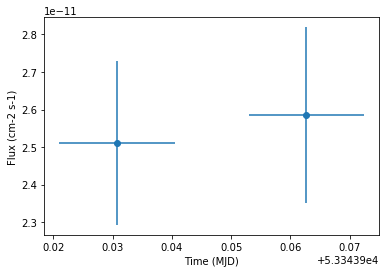

In [12]:
lc.plot()

## Exercises

* Change the assumed spectral model shape (e.g. to a steeper power-law), and see how the integral flux estimate for the lightcurve changes.
* Try a time binning where you split the observation time for every run into two time bins.